## Gamma-ray energy deposition

This notebook provides the initial implementation of Gamma-ray energy deposition into an arbitrary ejecta.
It is a WORK IN PROGRESS and should NOT be used for any science work until further notice.

### Main loop

Generates a simple 1D ejecta and a list of gamma-ray objects.

Runs packets of gamma-rays through the ejecta. Handles interactions by calling the appropriate function. 

Adds deposited energy and output energy to 2 different dataframes.

In [1]:
import numpy as np
import astropy.units as u

from tardis.energy_input.base import main_gamma_ray_loop

import matplotlib.pyplot as plt
from tardis.model import Radial1DModel
from tardis.io.config_reader import Configuration

# Set up packet count
num_packets = 10000
num_packets = int(num_packets)

# Lock seed
np.random.seed(1)

# Adjust model
config = Configuration.from_yaml("../../tardis/io/tests/data/tardis_configv1_density_exponential_nebular.yml")
config.model.structure.velocity.start = 1 * u.km / u.s
config.model.structure.density.rho_0 = 5e2 * u.g / (u.cm ** 3)

# Create model
model = Radial1DModel.from_config(config)

# Compute energy deposition rate
# ejecta_energy_df is the deposited energy
# ejecta_plot_energy_df is information for plotting
# escape_energy is the escaping energy
(
    ejecta_energy_df,
    ejecta_plot_energy_df,
    escape_energy
) = main_gamma_ray_loop(
    num_packets,
    model,
)

ejecta_energy = ejecta_plot_energy_df["energy_input"]
ejecta_energy_r = ejecta_plot_energy_df["energy_input_r"]
energy_input_time = ejecta_plot_energy_df["energy_input_time"]
energy_input_type = ejecta_plot_energy_df["energy_input_type"]

/home/afullard/miniconda3/envs/tardis/lib/python3.7/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
Ni56 is already in the database (force_update to overwrite)
Data Type Gamma Coincidence Data not known and not parsed
Data Type download-timestamp not known and not parsed
Ni57 is already in the database (force_update to overwrite)
Data Type Author not known and not parsed
Data Type Gamma Coincidence Data not known and not parsed
Data Type download-timestamp not known and not parsed


  0%|          | 0/10002 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Plotting results

Energy deposited at a given radius with a given interaction type where -1 = beta decay, 0 = Compton scattering, 1 = photoabsorption, 2 = pair creation

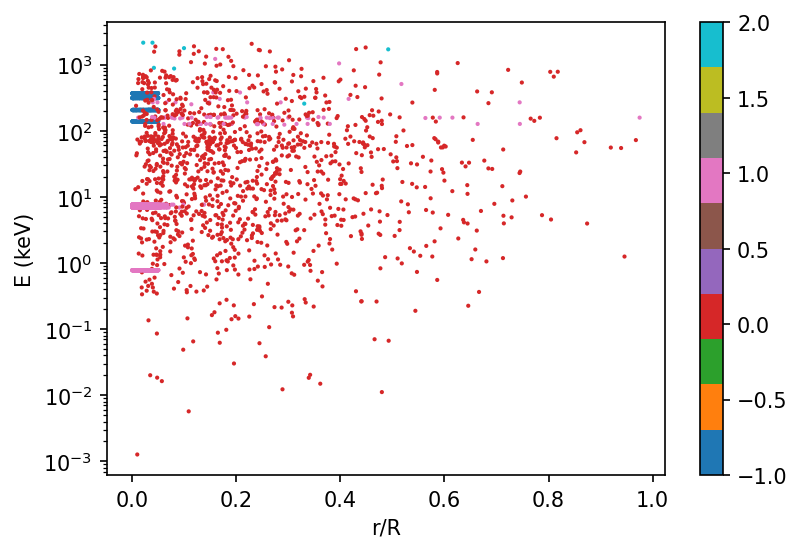

In [ ]:
fig = plt.figure(dpi=150, facecolor='w')
ax = fig.add_subplot(111)

scatter = ax.scatter(np.array(ejecta_energy_r)/np.max(model.v_outer.value), np.array(ejecta_energy), c=energy_input_type, s=1, cmap="tab10")
cbar = plt.colorbar(scatter, ax=ax)
ax.set_xlabel("r/R")
ax.set_ylabel("E (keV)")
ax.semilogy();

# Compton scattering energy deposition as a function of radius and viewing angle

Color bar shows energy in keV

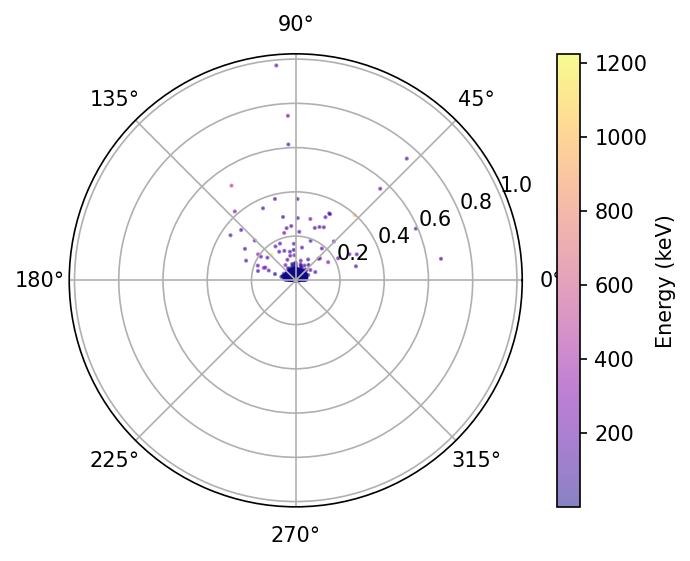

In [ ]:
ejecta_energy_theta = ejecta_plot_energy_df["energy_input_theta"]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, dpi=150, facecolor='w')
plot = ax.scatter(np.array(ejecta_energy_theta)[np.array(energy_input_type) == 1], np.array(ejecta_energy_r)[np.array(energy_input_type) == 1]/np.max(model.v_outer[:].value), c=np.array(ejecta_energy)[np.array(energy_input_type) == 1], s=1, alpha=0.5, cmap="plasma")
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Energy (keV)");

# Interactions binned by radius

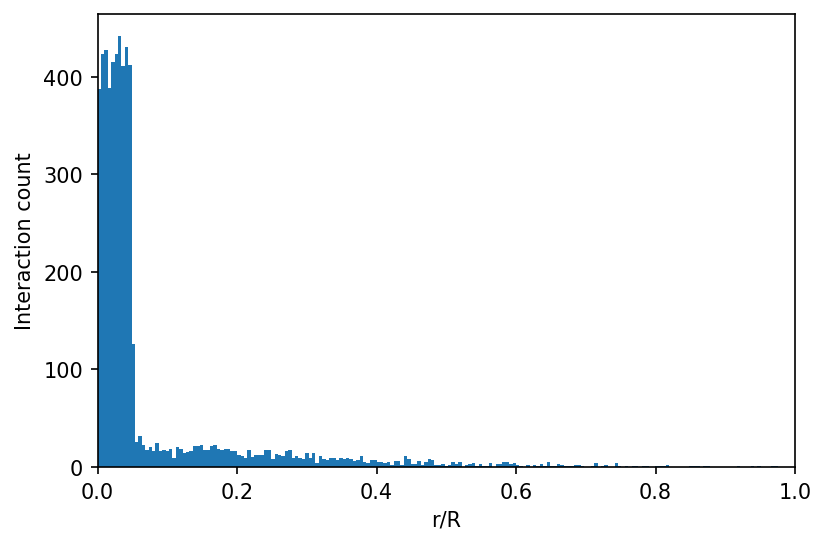

In [ ]:
fig = plt.figure(dpi=150, facecolor='w')
ax = fig.add_subplot(111)
ax.hist(np.array(ejecta_energy_r)/np.max(model.v_outer[:].value), bins=200)
ax.set_xlim(0, 1)
ax.set_xlabel("r/R")
ax.set_ylabel("Interaction count");

# Density Profile

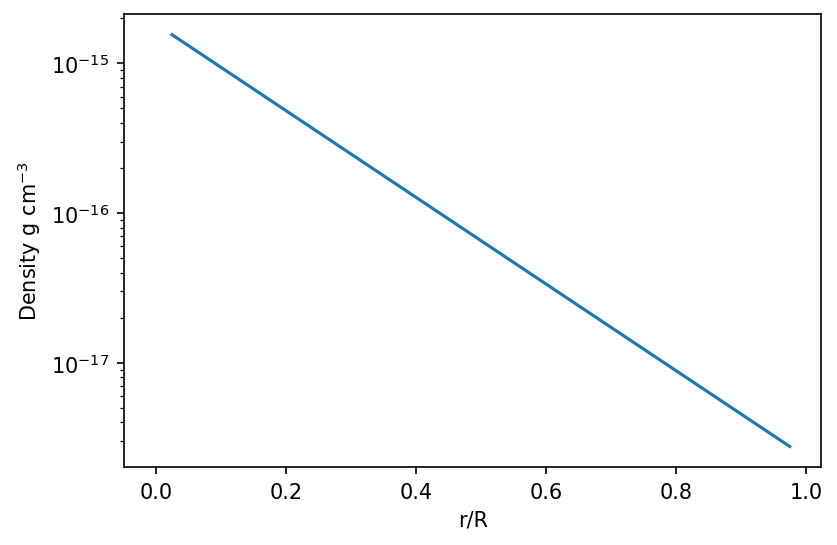

In [ ]:
fig = plt.figure(dpi=150, facecolor='w')
plt.semilogy(model.r_middle/np.max(model.r_outer), model.density)
plt.plot(0,0)
plt.ylabel("Density g cm$^{-3}$")
plt.xlabel("r/R");

# Fraction of energy escaping from the ejecta

In [ ]:
np.sum(escape_energy) / (np.sum(escape_energy) + np.sum(ejecta_energy))

0.9289445127150796

# Histogram of escape energy

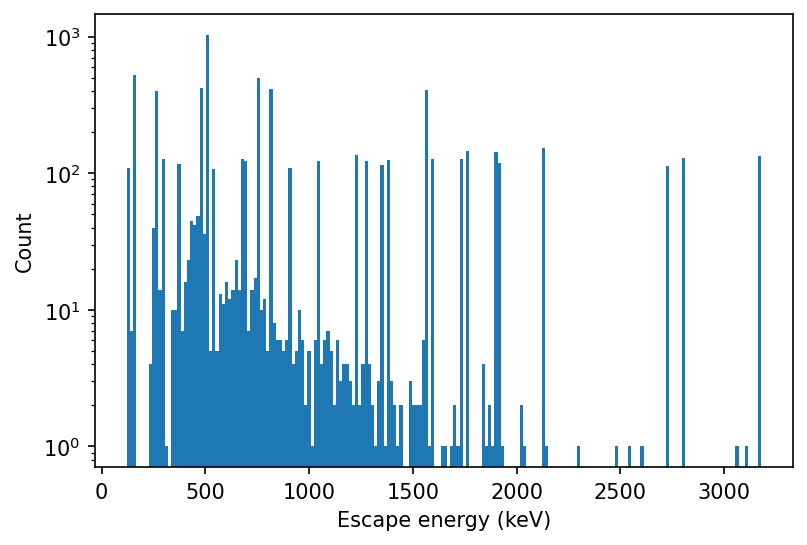

In [ ]:
fig = plt.figure(dpi=150, facecolor='w')
ax = fig.add_subplot(111)
ax.hist(np.array(escape_energy), bins=200)
ax.semilogy()
ax.set_xlabel("Escape energy (keV)")
ax.set_ylabel("Count");

# Energy deposition rate

Dataframe index is the radial grid location.

In [ ]:
ejecta_energy_df

,energy [eV/s/cm^-3]
0,285757.684203
1,30377.313469
2,11710.121196
3,7804.189097
4,4048.167841
5,2463.165513
6,1678.324596
7,1106.084866
8,919.370673
9,585.903354


# Energy deposition rate versus radius

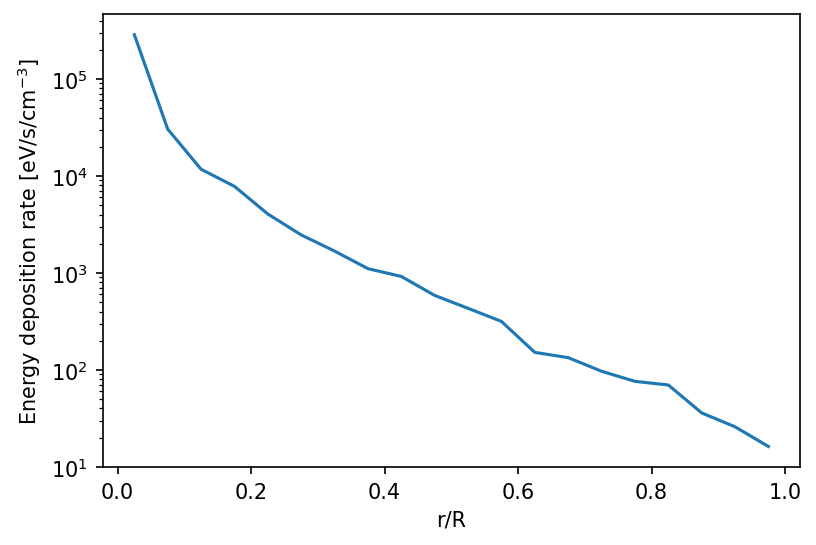

In [ ]:
fig = plt.figure(dpi=150, facecolor='w')
plt.semilogy(model.r_middle/np.max(model.r_outer), ejecta_energy_df)
plt.xlabel("r/R")
plt.ylabel("Energy deposition rate [eV/s/cm$^{-3}$]");